## Histogrammes

Types des colonnes :
Sub_metering_3           float64
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

Colonnes numériques utilisées :
Index(['Sub_metering_3', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2'],
      dtype='object')


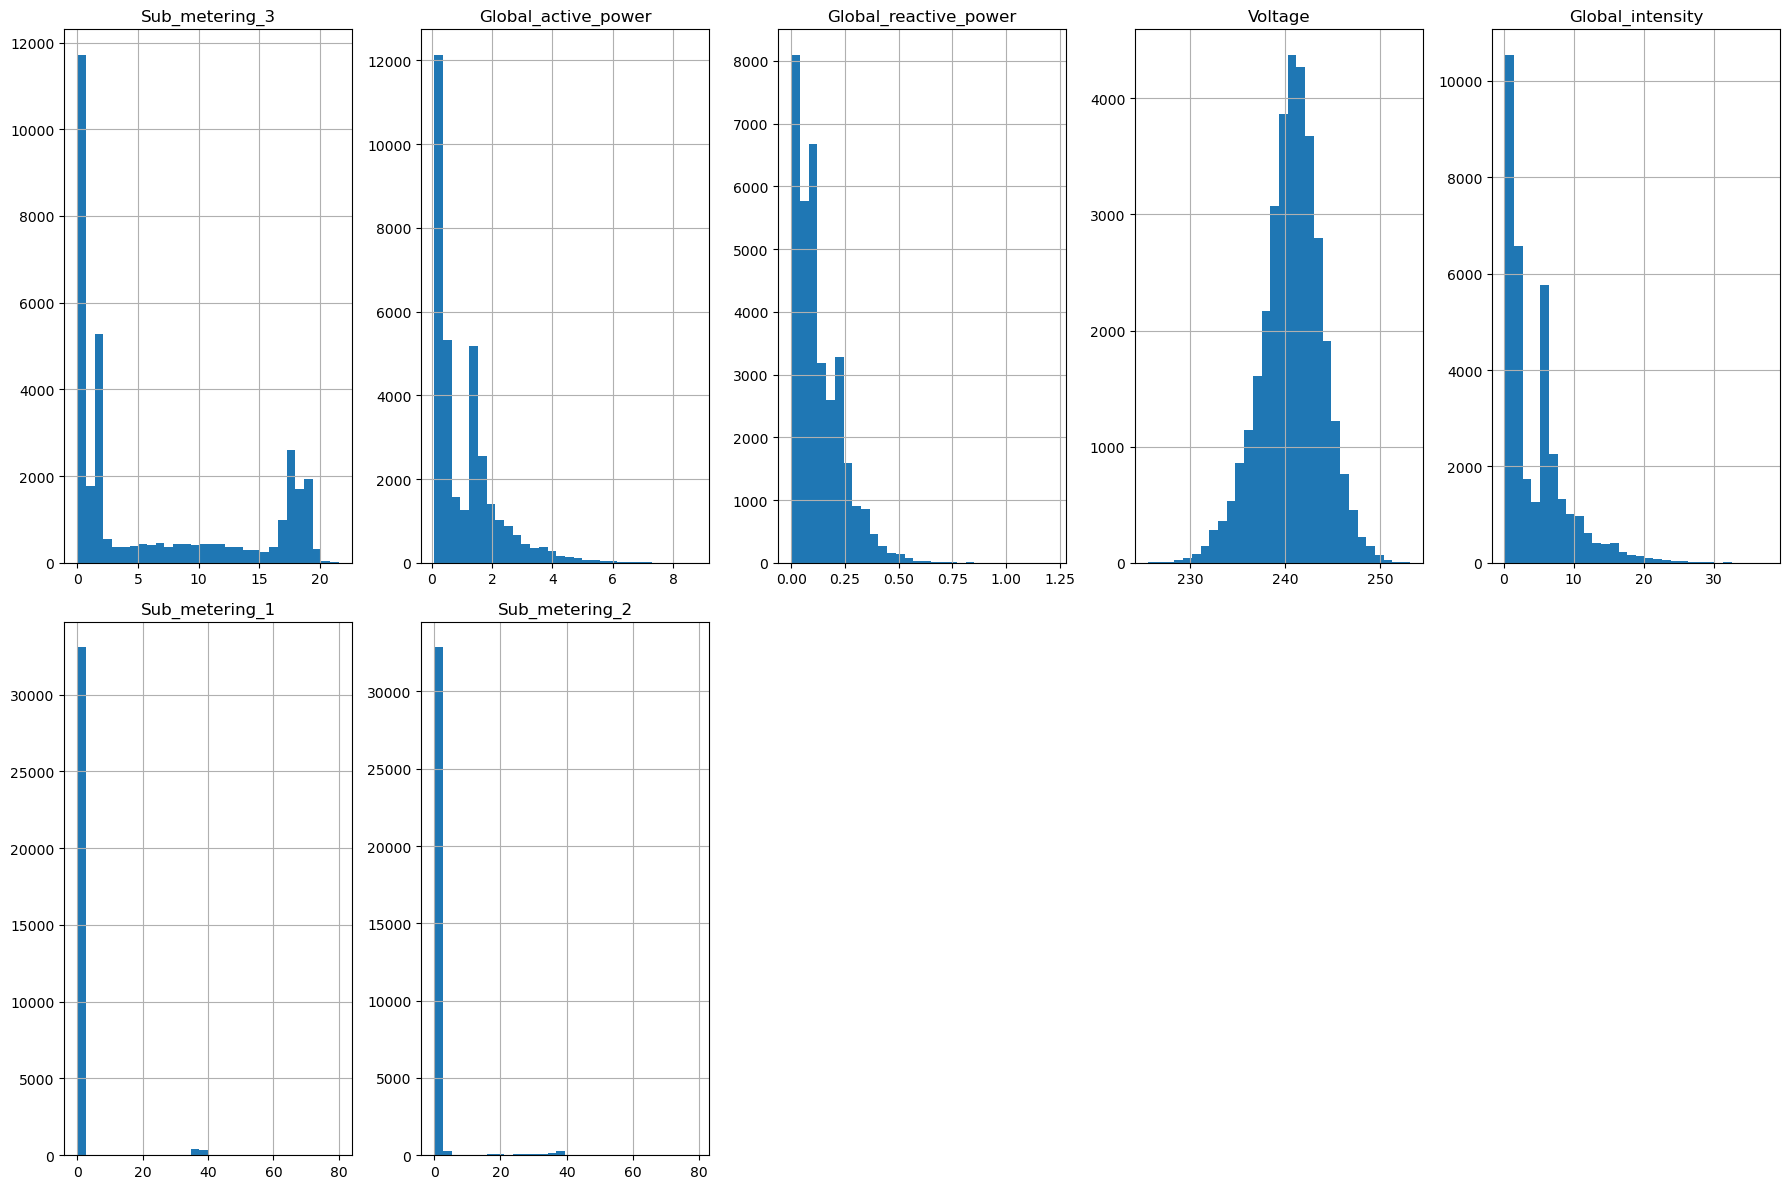

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ Afficher les types de données (debug)
print("Types des colonnes :")
print(df1.dtypes)

# 2️⃣ Garder uniquement les colonnes numériques
df1_numeric = df1.select_dtypes(include=['int64', 'float64'])

print("\nColonnes numériques utilisées :")
print(df1_numeric.columns)

# 3️⃣ Nombre de colonnes numériques
num_columns = len(df1_numeric.columns)

# 4️⃣ Configuration de la grille (5 graphiques par ligne)
cols = 5
rows = (num_columns // cols) + (1 if num_columns % cols != 0 else 0)

# 5️⃣ Tracer les histogrammes
df1_numeric.hist(figsize=(18, 12), bins=30, layout=(rows, cols))

plt.tight_layout()
plt.show()


## Detection des outliers et le supprimer 

In [12]:
import pandas as pd

# Sélectionner uniquement les colonnes numériques
df_num = df1.select_dtypes(include=['float64', 'int64'])

# Calcul IQR et filtrage
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

# Détection des outliers
outliers = (df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))
print("Nombre d'outliers par colonne :")
print(outliers.sum())

# Suppression des outliers
df_clean = df1[~outliers.any(axis=1)]

print("\nTaille originale :", df1.shape)
print("Taille après suppression :", df_clean.shape)


Nombre d'outliers par colonne :
Sub_metering_3              0
Global_active_power      1584
Global_reactive_power     676
Voltage                   832
Global_intensity         1703
Sub_metering_1           2824
Sub_metering_2           1299
dtype: int64

Taille originale : (34168, 7)
Taille après suppression : (28981, 7)


In [18]:
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df1.set_index('Datetime', inplace=True)
df.columns

Index(['Datetime', 'Sub_metering_3', 'Date', 'Time', 'Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2'],
      dtype='object')

## 1. Modèle de persistance (Median Forecasting)
Le modèle prédit toujours la médiane des valeurs passées

✔ Médiane sauvegardée dans median_model.pkl
✔ Scaler sauvegardé dans scaler.pkl
RMSE - Persistence Median: 0.9866627367576738


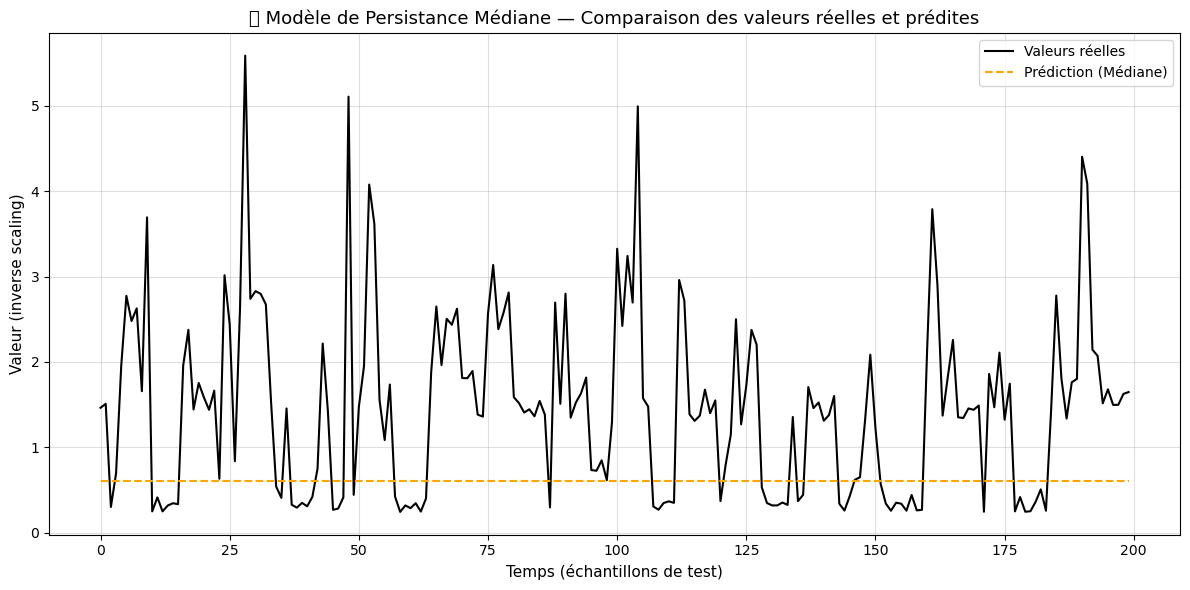

In [20]:
import numpy as np
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===========================
#   1) CALCUL DE LA MEDIANE
# ===========================
median_value = np.median(train)

# 🔥 Sauvegarde du modèle persistance médiane
joblib.dump(median_value, "median_model.pkl")
print("✔ Médiane sauvegardée dans median_model.pkl")

# 🔥 Sauvegarde du scaler
joblib.dump(scaler, "scaler.pkl")
print("✔ Scaler sauvegardé dans scaler.pkl")

# ===========================
#   2) PRÉDICTION MEDIANE
# ===========================
y_pred_median = np.full_like(y_test, median_value)

# ===========================
#   3) CALCUL RMSE
# ===========================
rmse_median = sqrt(mean_squared_error(
    scaler.inverse_transform(y_test.reshape(-1, 1)),
    scaler.inverse_transform(y_pred_median.reshape(-1, 1))
))
print("RMSE - Persistence Median:", rmse_median)

# ===========================
#   4) GRAPHIQUE
# ===========================
plt.figure(figsize=(12, 6))

plt.plot(
    scaler.inverse_transform(y_test.reshape(-1, 1))[:200],
    label='Valeurs réelles',
    color='black'
)

plt.plot(
    scaler.inverse_transform(y_pred_median.reshape(-1, 1))[:200],
    label='Prédiction (Médiane)',
    color='orange',
    linestyle='--'
)

plt.title("📈 Modèle de Persistance Médiane — Comparaison des valeurs réelles et prédites", fontsize=13)
plt.xlabel("Temps (échantillons de test)", fontsize=11)
plt.ylabel("Valeur (inverse scaling)", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


## 2. Modèle SARIMA

✔ Modèle SARIMA sauvegardé dans sarima_model.pkl
RMSE - SARIMA: 1.7922577425839263


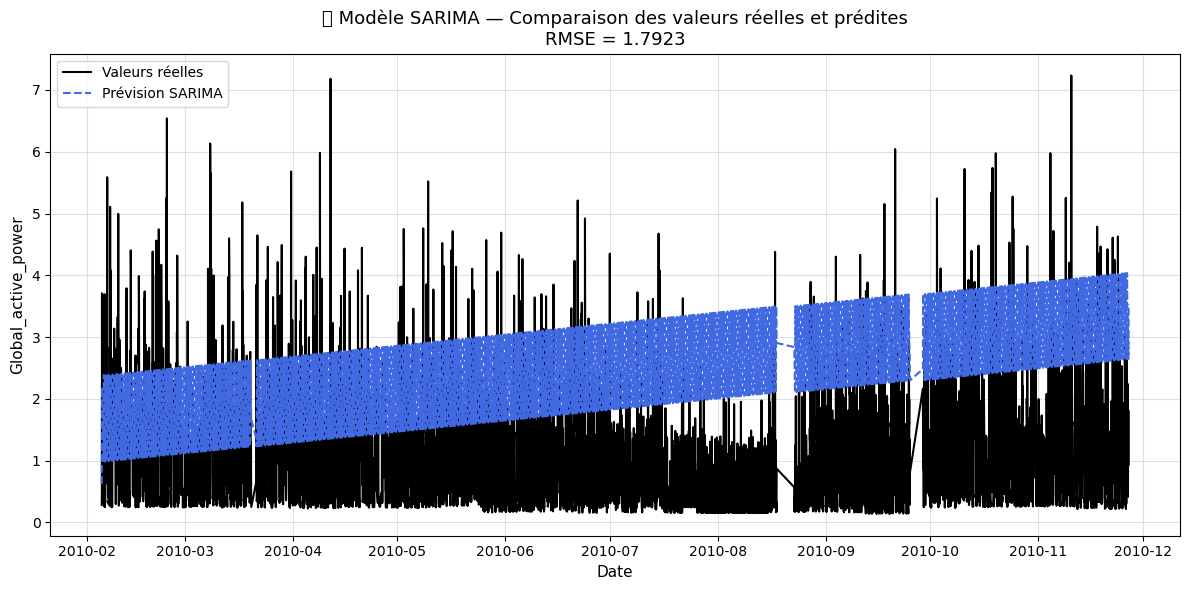

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===========================
#   1) TRAIN SARIMA
# ===========================
sarima_model = SARIMAX(
    df1[target_col][:train_size],
    order=(2,1,2),
    seasonal_order=(1,1,1,12)
)

sarima_fit = sarima_model.fit(disp=False)

# 🔥 Sauvegarde du modèle SARIMA
joblib.dump(sarima_fit, "sarima_model.pkl")
print("✔ Modèle SARIMA sauvegardé dans sarima_model.pkl")

# ===========================
#   2) FORECAST
# ===========================
sarima_forecast = sarima_fit.forecast(len(df1[target_col][train_size:]))

# ===========================
#   3) RMSE
# ===========================
rmse_sarima = sqrt(
    mean_squared_error(df1[target_col][train_size:], sarima_forecast)
)
print("RMSE - SARIMA:", rmse_sarima)

# ===========================
#   4) PLOT
# ===========================
plt.figure(figsize=(12, 6))

plt.plot(
    df1.index[train_size:],
    df1[target_col][train_size:],
    label='Valeurs réelles',
    color='black'
)

plt.plot(
    df1.index[train_size:],
    sarima_forecast,
    label='Prévision SARIMA',
    color='royalblue',
    linestyle='--'
)

plt.title(
    f"📈 Modèle SARIMA — Comparaison des valeurs réelles et prédites\nRMSE = {rmse_sarima:.4f}",
    fontsize=13
)

plt.xlabel("Date", fontsize=11)
plt.ylabel(target_col, fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


## 3. RNN simple

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE - RNN: 0.8100322891584317


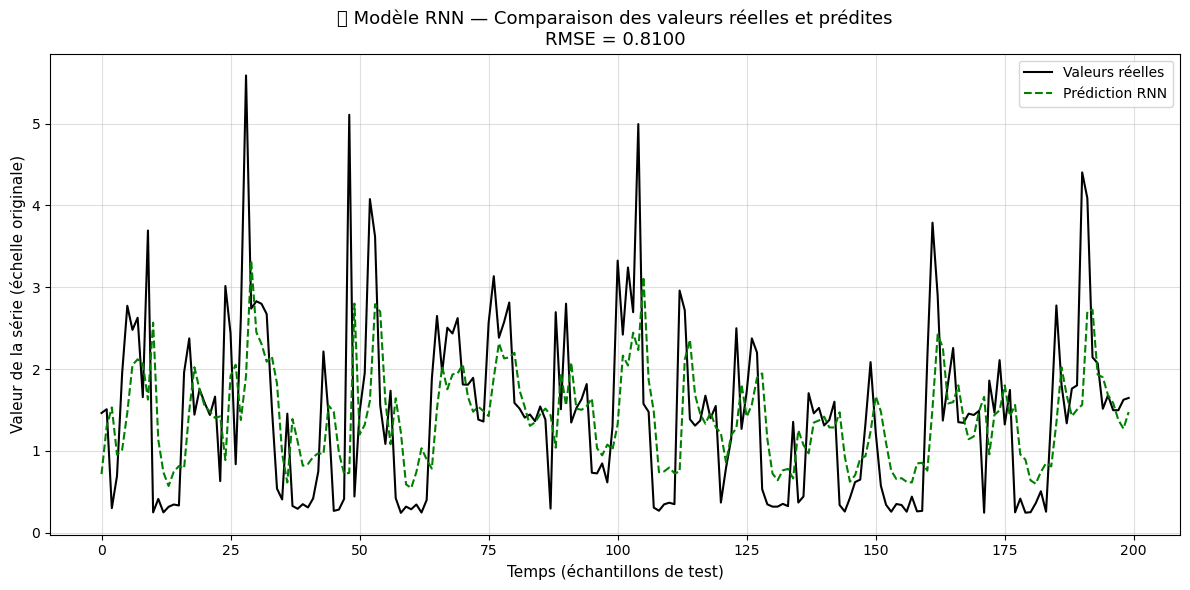

In [40]:
rnn = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(n_steps, 1)),
    Dense(1)
])
rnn.compile(optimizer='adam', loss='mse')
rnn.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=0)

y_pred_rnn = rnn.predict(X_test_seq)
rmse_rnn = sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),
                                   scaler.inverse_transform(y_pred_rnn)))
print("RMSE - RNN:", rmse_rnn)
plt.figure(figsize=(12, 6))

# Courbe des valeurs réelles
plt.plot(
    scaler.inverse_transform(y_test.reshape(-1, 1))[:200],
    label='Valeurs réelles',
    color='black'
)

# Courbe des prédictions RNN
plt.plot(
    scaler.inverse_transform(y_pred_rnn)[:200],
    label='Prédiction RNN',
    color='green',
    linestyle='--'
)

# Titre et légende
plt.title(f"📈 Modèle RNN — Comparaison des valeurs réelles et prédites\nRMSE = {rmse_rnn:.4f}", fontsize=13)
plt.xlabel("Temps (échantillons de test)", fontsize=11)
plt.ylabel("Valeur de la série (échelle originale)", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

## 4. LSTM Vanilla

✔ Modèle RNN sauvegardé dans rnn_model.h5
✔ Scaler sauvegardé dans scaler.pkl
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE - RNN: 0.799497247296254


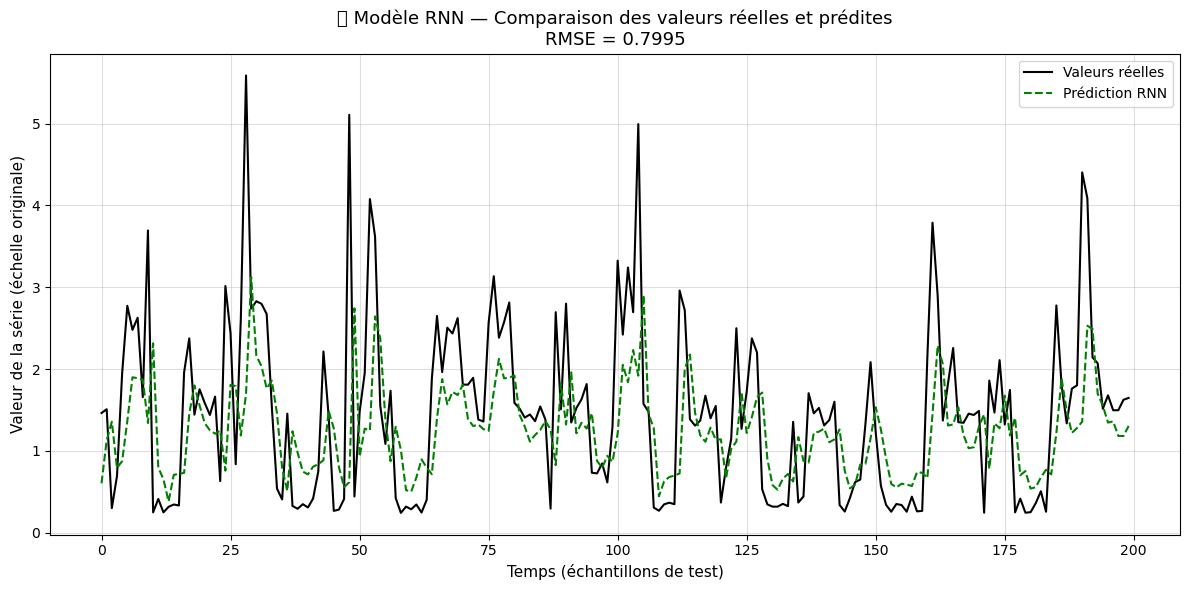

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===========================
#   1) BUILD & TRAIN RNN
# ===========================
rnn = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(n_steps, 1)),
    Dense(1)
])

rnn.compile(optimizer='adam', loss='mse')

rnn.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=0)

# 🔥 Sauvegarde du modèle RNN
rnn.save("rnn_model.h5")
print("✔ Modèle RNN sauvegardé dans rnn_model.h5")

# 🔥 Sauvegarde du scaler aussi (si utile)
joblib.dump(scaler, "scaler.pkl")
print("✔ Scaler sauvegardé dans scaler.pkl")

# ===========================
#   2) PREDICTION
# ===========================
y_pred_rnn = rnn.predict(X_test_seq)

# ===========================
#   3) RMSE
# ===========================
rmse_rnn = sqrt(mean_squared_error(
    scaler.inverse_transform(y_test.reshape(-1, 1)),
    scaler.inverse_transform(y_pred_rnn)
))
print("RMSE - RNN:", rmse_rnn)

# ===========================
#   4) PLOT
# ===========================
plt.figure(figsize=(12, 6))

plt.plot(
    scaler.inverse_transform(y_test.reshape(-1, 1))[:200],
    label='Valeurs réelles',
    color='black'
)

plt.plot(
    scaler.inverse_transform(y_pred_rnn)[:200],
    label='Prédiction RNN',
    color='green',
    linestyle='--'
)

plt.title(f"📈 Modèle RNN — Comparaison des valeurs réelles et prédites\nRMSE = {rmse_rnn:.4f}", fontsize=13)
plt.xlabel("Temps (échantillons de test)", fontsize=11)
plt.ylabel("Valeur de la série (échelle originale)", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


## 5. LSTM empilé (Stacked)

✔ Modèle LSTM Stacked sauvegardé dans lstm_stacked_model.h5
✔ Scaler sauvegardé dans scaler.pkl
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
RMSE - LSTM Stacked: 0.7892004824264369


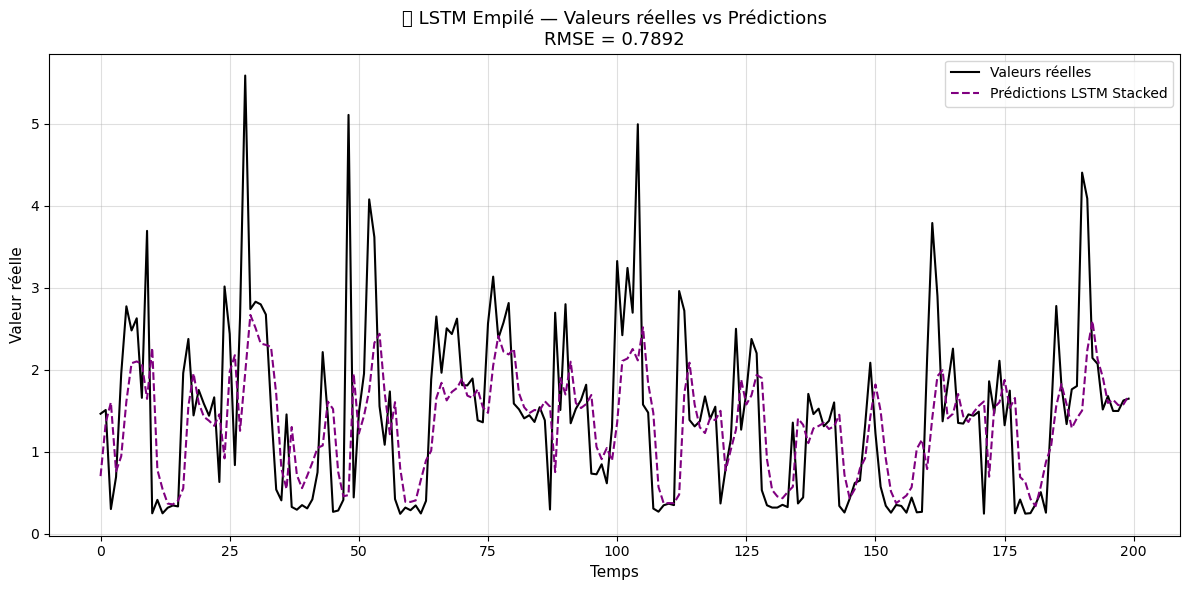

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===========================
#   1) BUILD & TRAIN LSTM STACKED
# ===========================
lstm_stacked = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(30, activation='tanh'),
    Dense(1)
])

lstm_stacked.compile(optimizer='adam', loss='mse')

lstm_stacked.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=0)

# 🔥 Sauvegarde du modèle LSTM empilé
lstm_stacked.save("lstm_stacked_model.h5")
print("✔ Modèle LSTM Stacked sauvegardé dans lstm_stacked_model.h5")

# 🔥 Sauvegarde du scaler utilisé
joblib.dump(scaler, "scaler.pkl")
print("✔ Scaler sauvegardé dans scaler.pkl")

# ===========================
#   2) PREDICTION
# ===========================
y_pred_stacked = lstm_stacked.predict(X_test_seq)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred_stacked)

# ===========================
#   3) RMSE
# ===========================
rmse_stacked = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("RMSE - LSTM Stacked:", rmse_stacked)

# ===========================
#   4) PLOT
# ===========================
plt.figure(figsize=(12, 6))

plt.plot(y_test_inv[:200], label='Valeurs réelles', color='black')
plt.plot(y_pred_inv[:200], label='Prédictions LSTM Stacked', color='purple', linestyle='--')

plt.title(f"📈 LSTM Empilé — Valeurs réelles vs Prédictions\nRMSE = {rmse_stacked:.4f}", fontsize=13)
plt.xlabel("Temps", fontsize=11)
plt.ylabel("Valeur réelle", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


## 6. LSTM bidirectionnel

✔ Modèle BiLSTM sauvegardé dans bilstm_model.h5
✔ Scaler sauvegardé dans scaler.pkl
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
RMSE - Bidirectional LSTM: 0.7899671560595084


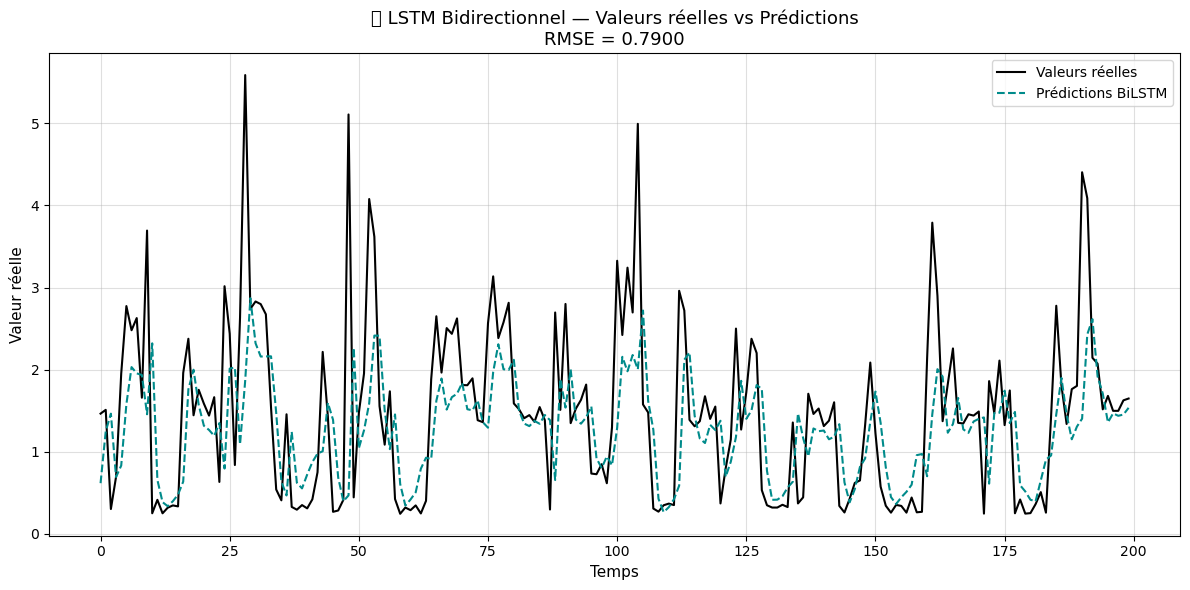

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===========================
#   1) BUILD & TRAIN BiLSTM
# ===========================
bilstm = Sequential([
    Bidirectional(LSTM(50, activation='tanh'), input_shape=(n_steps, 1)),
    Dense(1)
])

bilstm.compile(optimizer='adam', loss='mse')

bilstm.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=0)

# 🔥 Sauvegarde du modèle BiLSTM
bilstm.save("bilstm_model.h5")
print("✔ Modèle BiLSTM sauvegardé dans bilstm_model.h5")

# 🔥 Sauvegarde du scaler
joblib.dump(scaler, "scaler.pkl")
print("✔ Scaler sauvegardé dans scaler.pkl")

# ===========================
#   2) PREDICTION
# ===========================
y_pred_bilstm = bilstm.predict(X_test_seq)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred_bilstm)

# ===========================
#   3) RMSE
# ===========================
rmse_bilstm = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("RMSE - Bidirectional LSTM:", rmse_bilstm)

# ===========================
#   4) PLOT
# ===========================
plt.figure(figsize=(12, 6))

plt.plot(y_test_inv[:200], label='Valeurs réelles', color='black')
plt.plot(y_pred_inv[:200], label='Prédictions BiLSTM', color='darkcyan', linestyle='--')

plt.title(f"📈 LSTM Bidirectionnel — Valeurs réelles vs Prédictions\nRMSE = {rmse_bilstm:.4f}", fontsize=13)
plt.xlabel("Temps", fontsize=11)
plt.ylabel("Valeur réelle", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


## 7. MLP (Multi-Layer Perceptron)

✔ Modèle MLP sauvegardé dans mlp_model.h5
✔ Scaler sauvegardé dans scaler.pkl
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE - MLP: 0.8139007879489306


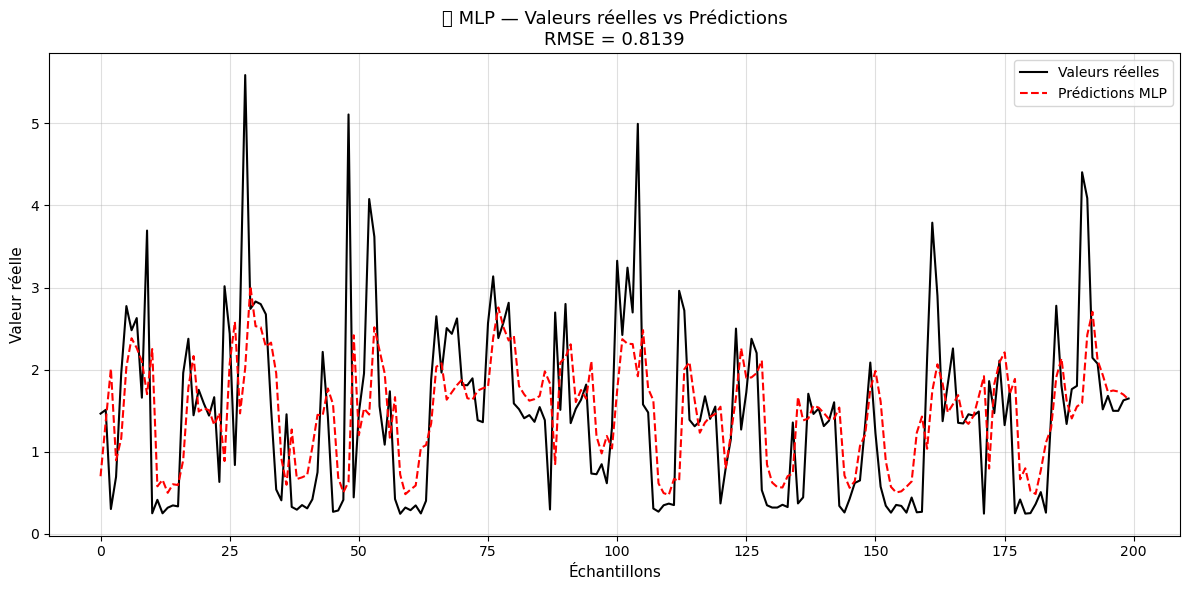

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===========================
#   1) BUILD & TRAIN MLP
# ===========================
mlp = Sequential([
    Dense(100, activation='relu', input_dim=n_steps),
    Dense(50, activation='relu'),
    Dense(1)
])

mlp.compile(optimizer='adam', loss='mse')

mlp.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# 🔥 Sauvegarde du modèle MLP
mlp.save("mlp_model.h5")
print("✔ Modèle MLP sauvegardé dans mlp_model.h5")

# 🔥 Sauvegarde du scaler (si pas déjà fait)
joblib.dump(scaler, "scaler.pkl")
print("✔ Scaler sauvegardé dans scaler.pkl")

# ===========================
#   2) PREDICTION
# ===========================
y_pred_mlp = mlp.predict(X_test)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred_mlp)

# ===========================
#   3) RMSE
# ===========================
rmse_mlp = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("RMSE - MLP:", rmse_mlp)

# ===========================
#   4) PLOT
# ===========================
plt.figure(figsize=(12, 6))

plt.plot(y_test_inv[:200], label='Valeurs réelles', color='black')
plt.plot(y_pred_inv[:200], label='Prédictions MLP', color='red', linestyle='--')

plt.title(f"📈 MLP — Valeurs réelles vs Prédictions\nRMSE = {rmse_mlp:.4f}", fontsize=13)
plt.xlabel("Échantillons", fontsize=11)
plt.ylabel("Valeur réelle", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


## 8. CNN

✔ Modèle CNN sauvegardé dans cnn_model.h5
✔ Scaler sauvegardé dans scaler.pkl
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE - CNN: 0.8498344004747151


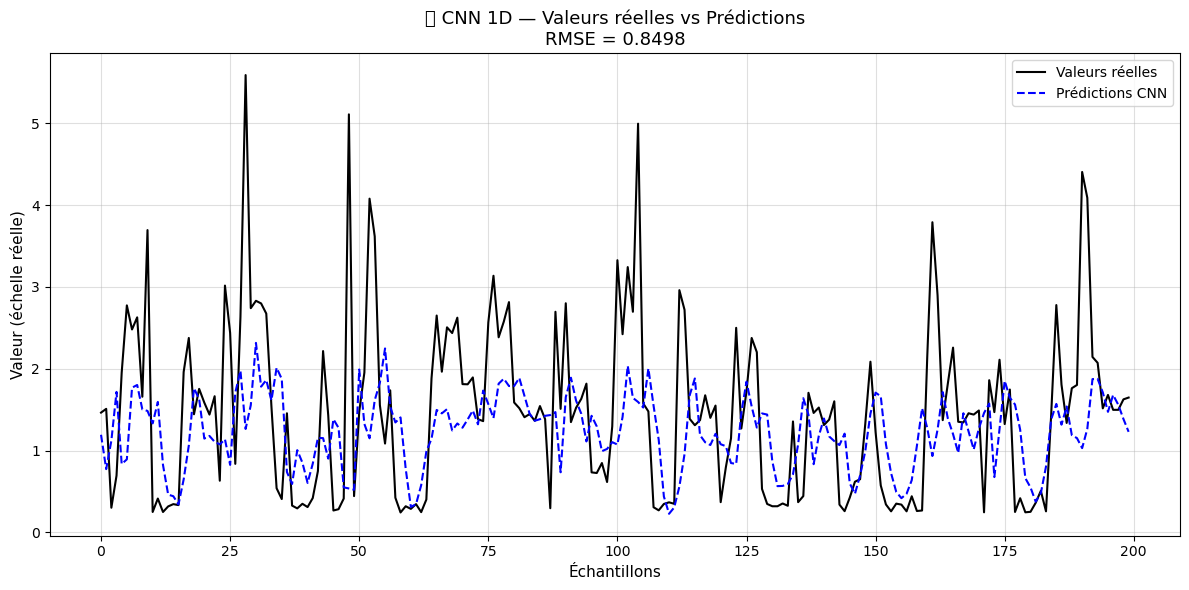

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===========================
#   1) BUILD & TRAIN CNN 1D
# ===========================
cnn = Sequential([
    Conv1D(64, 2, activation='relu', input_shape=(n_steps, 1)),
    MaxPooling1D(),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

cnn.compile(optimizer='adam', loss='mse')

cnn.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=0)

# 🔥 Sauvegarde du modèle CNN
cnn.save("cnn_model.h5")
print("✔ Modèle CNN sauvegardé dans cnn_model.h5")

# 🔥 Sauvegarde du scaler (si pas déjà fait)
joblib.dump(scaler, "scaler.pkl")
print("✔ Scaler sauvegardé dans scaler.pkl")

# ===========================
#   2) PREDICTION
# ===========================
y_pred_cnn = cnn.predict(X_test_seq)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred_cnn)

# ===========================
#   3) RMSE
# ===========================
rmse_cnn = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("RMSE - CNN:", rmse_cnn)

# ===========================
#   4) PLOT
# ===========================
plt.figure(figsize=(12, 6))

plt.plot(y_test_inv[:200], label='Valeurs réelles', color='black')
plt.plot(y_pred_inv[:200], label='Prédictions CNN', color='blue', linestyle='--')

plt.title(f"📈 CNN 1D — Valeurs réelles vs Prédictions\nRMSE = {rmse_cnn:.4f}", fontsize=13)
plt.xlabel("Échantillons", fontsize=11)
plt.ylabel("Valeur (échelle réelle)", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


## K-Means model ##

=== KMEANS ===
Silhouette : 0.7189658568257941
Davies-Bouldin : 0.5634321172649633
Calinski-Harabasz : 14874.286307583598
Inertia : 2864588.9249867476
RMSE KMeans : 9.158339213178355


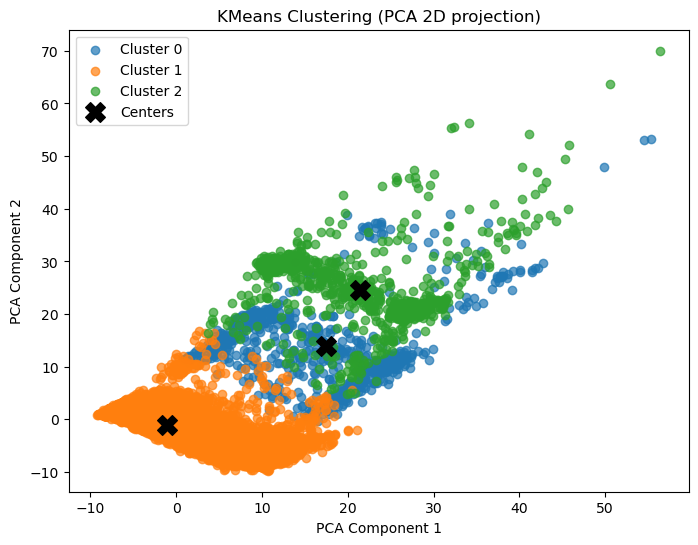

['kmeans_model.pkl']

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import numpy as np

# --- 1. Prepare data ---
X_cluster = df1.drop(columns=["Global_active_power"])

# --- 2. Fit KMeans ---
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_cluster)

# --- 3. Clustering metrics ---
sil_score = silhouette_score(X_cluster, labels_km)
db_score = davies_bouldin_score(X_cluster, labels_km)
ch_score = calinski_harabasz_score(X_cluster, labels_km)
inertia = kmeans.inertia_

rmse_kmeans = np.sqrt(inertia / len(X_cluster))

print("=== KMEANS ===")
print("Silhouette :", sil_score)
print("Davies-Bouldin :", db_score)
print("Calinski-Harabasz :", ch_score)
print("Inertia :", inertia)
print("RMSE KMeans :", rmse_kmeans)

# --- 4. PCA for 2D visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(8,6))
for label in np.unique(labels_km):
    plt.scatter(
        X_pca[labels_km == label, 0],
        X_pca[labels_km == label, 1],
        label=f'Cluster {label}',
        alpha=0.7
    )

# Plot cluster centers transformed by PCA
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='black', marker='X', s=200, label='Centers')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clustering (PCA 2D projection)")
plt.legend()
plt.show()
joblib.dump(kmeans, "kmeans_model.pkl")


## DBSCAN #

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
import joblib
import json

# --- 1. Fit DBSCAN ---
db = DBSCAN(eps=0.5, min_samples=5)
labels_db = db.fit_predict(X_cluster)

print("=== DBSCAN ===")
print("Clusters (including -1 for noise) :", set(labels_db))

# --- 2. Silhouette score (ignore noise) ---
mask = labels_db != -1  # ignore noise
if len(set(labels_db[mask])) > 1:  # silhouette needs ≥2 clusters
    sil_score = silhouette_score(X_cluster[mask], labels_db[mask])
    print("Silhouette score (non-noise) :", sil_score)
else:
    sil_score = None
    print("Silhouette score not defined (less than 2 clusters)")

# --- 3. Compute pseudo-RMSE ---
rmse_list = []
unique_labels = set(labels_db)
unique_labels.discard(-1)  # ignore noise

for label in unique_labels:
    cluster_points = X_cluster[labels_db == label]
    center = cluster_points.mean(axis=0)
    mse = np.mean(np.sum((cluster_points - center)**2, axis=1))
    rmse_list.append(np.sqrt(mse))

if rmse_list:
    rmse_dbscan = float(np.mean(rmse_list))
    print("Pseudo RMSE per cluster :", rmse_list)
    print("Average pseudo RMSE :", rmse_dbscan)
else:
    rmse_dbscan = None
    print("No clusters to compute RMSE")

# ===========================
#       SAUVEGARDE
# ===========================

# 1. Sauvegarde du modèle DBSCAN
joblib.dump(db, "dbscan_model.pkl")
joblib.dump(labels_db, "dbscan_labels.pkl")

# 2. Sauvegarde des métriques
metrics = {
    "silhouette_score": sil_score,
    "rmse_per_cluster": rmse_list,
    "average_rmse": rmse_dbscan,
    "n_clusters": len(unique_labels),
    "noise_points": int((labels_db == -1).sum())
}

with open("dbscan_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("DBSCAN + labels + métriques sauvegardés !")


=== DBSCAN ===
Clusters (including -1 for noise) : {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int